# Extended Cox model (recurrent events, time varying features)

In this notebook I implemented the pipeline for the fitting of the realizations of the compensator of the counting process about the purchases of ACE drugs.

The data comes from patients affected by heart disease in a follow-up interval of one year from the exit-time of the first hospitalization. 

The following steps are made:

1. Model choice
    - cross validation
    - a deeper exploration
2. Model fitting
3. Smoothing of baseline Hazard
4. Reconstruction of the patient-specific cumulative Hazards
5. Check of Martingale residuals

**Note:** the chosen model is of the form $h(t|x_i) = \lambda_0(t)\times \alpha_1^{N_i(t-)}\times \alpha_2^{y_i(t-)} \times e^{\beta*age_i}$

In [1]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines

options(repr.plot.width=6, repr.plot.height=4)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: survival


In [2]:
path = '/Users/davide/Documents/universita/tesi/src/pharmacological_counting_process'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data.RData')

In [3]:
# preprocessed data
head(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,sum_past_qt_prest
10000717,-0.5,101.0,1,M,72,0,0
10000717,101.0,130.0,1,M,72,1,56
10000717,130.0,176.0,1,M,72,2,112
10000717,176.0,197.0,1,M,72,3,168
10000717,197.0,212.0,1,M,72,4,182
10000717,212.0,247.0,1,M,72,5,238
10000717,247.0,344.0,1,M,72,6,350
10000717,344.0,365.5,0,M,72,7,406


# Model Choice

## Evaluate goodness of fit 
We use cross-validated C-index to choose the best model

In [24]:
set.seed(123)
#Randomly shuffle the patients
patients = sample(unique(sel_df$id))
#Create 10 equally size folds
folds <- cut(seq(1,length(patients)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
scores = NULL
pb <- txtProgressBar(min = 0, max = 10, style = 3)
for(i in 1:10){
    setTxtProgressBar(pb, i)
    #Segement patients by fold 
    validIndexes <- which(folds==i,arr.ind=TRUE)
    valid_patients <- patients[validIndexes]
    train_patients <- patients[-validIndexes]
    # Split train, valid
    train = sel_df[id %in% train_patients]
    valid = sel_df[id %in% valid_patients]
    
    # fit
    models = list(
        model0 = coxph(Surv(start,stop,status)~ age_in + Nm + cluster(id), data = train),
        model1 = coxph(Surv(start,stop,status)~ age_in + sum_past_qt_prest + cluster(id), data = train),
        model2 = coxph(Surv(start,stop,status)~ age_in + Nm + sum_past_qt_prest + cluster(id), data = train),
        model3 = coxph(Surv(start,stop,status)~ age_in + Nm:sum_past_qt_prest + cluster(id), data = train),
        model4 = coxph(Surv(start,stop,status)~ age_in + Nm + Nm:sum_past_qt_prest + cluster(id), data = train),
        model5 = coxph(Surv(start,stop,status)~ age_in + sum_past_qt_prest + Nm:sum_past_qt_prest + cluster(id), data = train),
        model6 = coxph(Surv(start,stop,status)~ age_in + Nm + sum_past_qt_prest + Nm:sum_past_qt_prest + cluster(id), data = train)
    )
    # predict, evaluate
    fold_scores = c()
    for(model in models){
        prediction = predict(model, newdata = valid)
        # evaluate concordance probability
        score = survConcordance(Surv(start,stop,status) ~ prediction, data = valid)$concordance[[1]]
        fold_scores = c(fold_scores,score)
    }
    scores = rbind(scores,fold_scores)
}
rownames(scores) = 1:10
colnames(scores) = names(models)

  |======================================================================| 100%

In [45]:
# print cv scores
mean_scores = colMeans(scores)
model_names = colnames(scores)
print('Cross validation concordance probability')
for(i in 1:length(models)){
    print(paste(model_names[i],':',round(mean_scores[i]*100,1),'%'))
}

[1] "Cross validation concordance probability"
[1] "model0 : 57 %"
[1] "model1 : 54.7 %"
[1] "model2 : 57.4 %"
[1] "model3 : 54.3 %"
[1] "model4 : 43.5 %"
[1] "model5 : 54.3 %"
[1] "model6 : 57.2 %"


## A deeper exploration

Apparently the best model (model2) considers the 2 features Nm and sum_past_qt_prest as independent; however let's check the significance of the features also in other cases.

### Original idea

Let:
- $N_i(t-) = Nm $ 
- $y_i(t-) = $ sum of past qt_prest_sum for patient $i$

Then the original idea was to fit a model of the form: 

$h(t|x_i) = \lambda_0(t)\times \alpha^{N_i(t-)*y_i(t-)}\times e^{\beta*age_i}$

In [27]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm:sum_past_qt_prest + cluster(id), data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm:sum_past_qt_prest + 
    cluster(id), data = sel_df)

                           coef  exp(coef)   se(coef)  robust se      z
age_in               -2.828e-03  9.972e-01  5.832e-04  8.140e-04 -3.474
Nm:sum_past_qt_prest  5.429e-05  1.000e+00  1.642e-06  2.600e-06 20.879
                            p
age_in               0.000512
Nm:sum_past_qt_prest  < 2e-16

Likelihood ratio test=867  on 2 df, p=< 2.2e-16
n= 24770, number of events= 21854 

For this model, we notice that all the coefficients are significative, but the **cross validation C-index performs 3.1% worse than the best model**.

### Indipendent model

Let's consider $N_i(t-)$ as independent from $y_i(t-)$. The model can be written as:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{N_i(t-)}\times \alpha_2^{y_i(t-)} \times e^{\beta*age_i}$

This model has the best score in terms of C-index cross validation and all the coefficients appear to be significative.

In [30]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm + sum_past_qt_prest + cluster(id), data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm + sum_past_qt_prest + 
    cluster(id), data = sel_df)

                        coef  exp(coef)   se(coef)  robust se      z        p
age_in            -2.287e-03  9.977e-01  5.820e-04  5.836e-04 -3.918 8.92e-05
Nm                 1.182e-01  1.125e+00  2.927e-03  2.292e-03 51.554  < 2e-16
sum_past_qt_prest -2.417e-04  9.998e-01  3.534e-05  2.755e-05 -8.775  < 2e-16

Likelihood ratio test=2057  on 3 df, p=< 2.2e-16
n= 24770, number of events= 21854 

### Full model

Let's consider the "full model", i.e.:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{N_i(t-)}\times \alpha_2^{y_i(t-)} \alpha_3^{N_i(t-)y_i(t-)} \times e^{\beta*age_i}$

In [41]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm + sum_past_qt_prest +  Nm:sum_past_qt_prest + cluster(id), data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm + sum_past_qt_prest + 
    Nm:sum_past_qt_prest + cluster(id), data = sel_df)

                           coef  exp(coef)   se(coef)  robust se      z
age_in               -2.201e-03  9.978e-01  5.820e-04  5.699e-04 -3.862
Nm                    1.341e-01  1.144e+00  3.849e-03  3.809e-03 35.219
sum_past_qt_prest    -2.827e-05  1.000e+00  4.861e-05  4.349e-05 -0.650
Nm:sum_past_qt_prest -2.783e-05  1.000e+00  4.459e-06  3.919e-06 -7.102
                            p
age_in               0.000112
Nm                    < 2e-16
sum_past_qt_prest    0.515635
Nm:sum_past_qt_prest 1.23e-12

Likelihood ratio test=2098  on 4 df, p=< 2.2e-16
n= 24770, number of events= 21854 

**Sum_past_qt_prest** is not significative; let's try to remove it:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{N_i(t-)}\times \alpha_2^{N_i(t-)y_i(t-)} \times e^{beta*age_i}$

In [42]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm +  Nm:sum_past_qt_prest + cluster(id), data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm + Nm:sum_past_qt_prest + 
    cluster(id), data = sel_df)

                           coef  exp(coef)   se(coef)  robust se       z
age_in               -2.188e-03  9.978e-01  5.816e-04  5.682e-04  -3.851
Nm                    1.344e-01  1.144e+00  3.829e-03  3.677e-03  36.544
Nm:sum_past_qt_prest -2.964e-05  1.000e+00  3.225e-06  2.651e-06 -11.179
                            p
age_in               0.000118
Nm                    < 2e-16
Nm:sum_past_qt_prest  < 2e-16

Likelihood ratio test=2097  on 3 df, p=< 2.2e-16
n= 24770, number of events= 21854 

In the latter model, all the coefficient are significative; however this correspond to the worst model in term of cross validation.

# Fit model

We decided to keep the independent model, i.e.:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{N_i(t-)}\times \alpha_2^{y_i(t-)} \times e^{\beta*age_i}$

In [46]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm + sum_past_qt_prest + cluster(id), data = sel_df)

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm + sum_past_qt_prest + 
    cluster(id), data = sel_df)

                        coef  exp(coef)   se(coef)  robust se      z        p
age_in            -2.287e-03  9.977e-01  5.820e-04  5.836e-04 -3.918 8.92e-05
Nm                 1.182e-01  1.125e+00  2.927e-03  2.292e-03 51.554  < 2e-16
sum_past_qt_prest -2.417e-04  9.998e-01  3.534e-05  2.755e-05 -8.775  < 2e-16

Likelihood ratio test=2057  on 3 df, p=< 2.2e-16
n= 24770, number of events= 21854 

In [59]:
alpha1 = exp(model$coefficients['Nm'])
alpha2 = exp(model$coefficients['sum_past_qt_prest'])
beta = model$coefficients['age_in']

print(paste('alpha_1:',alpha1))
print(paste('alpha_2:',alpha2))
print(paste('beta:',beta))

[1] "alpha_1: 1.12543450498577"
[1] "alpha_2: 0.999758310474256"
[1] "beta: -0.00228677540871133"


We notice that:
- $\alpha_1 > 1$ : More pharmacological purchases cause more purchases in the future
- $\alpha_2 < 1$ : More days of drugs coverage bought in the past  cause less purchases in the future

Interestingly, $\beta < 0$. This means that older patients have less drugs purchases than the younger (but maybe more consistent?)

# Compute and smooth baseline Hazards

In [47]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [48]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(0,0,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


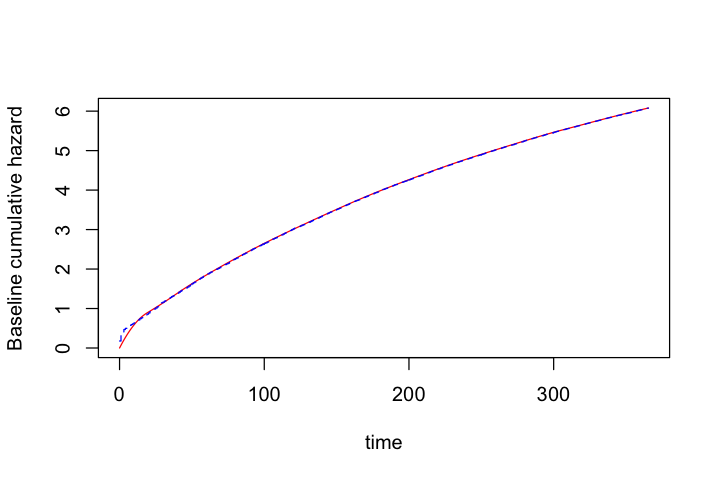

In [49]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

# Reconstruct patients cumulative Hazards

In [50]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

[1] "Computing coefficients ck"
  |======================================================================| 100%[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%

In [51]:
head(cumulative_hazard)

id,time,cumhaz
10000717,0,2.927572e-13
10000717,1,5.958548e-02
10000717,2,1.169598e-01
10000717,3,1.721230e-01
10000717,4,2.250751e-01
10000717,5,2.758160e-01


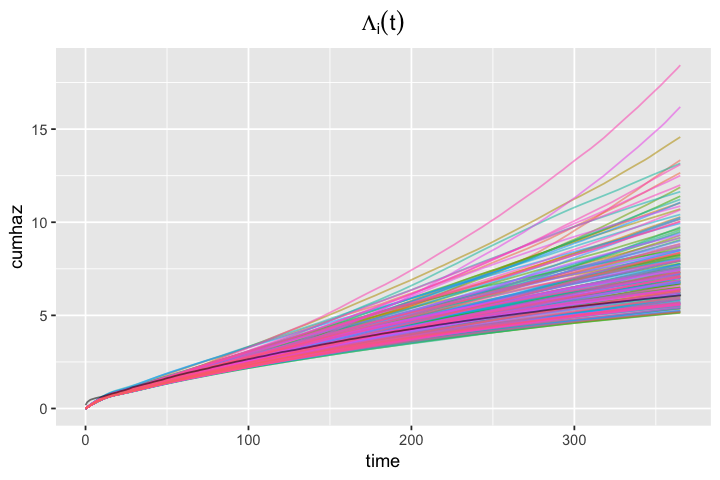

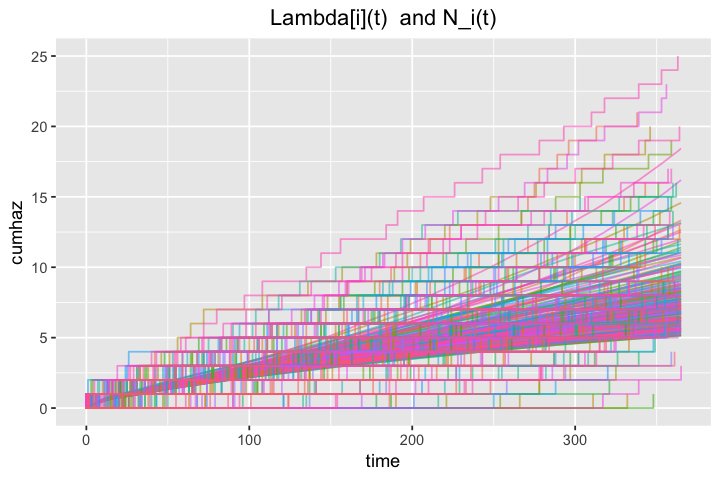

In [52]:
# select a sample to plot
sample_patients = sample(unique(sel_df$id),200)
sample = cumulative_hazard[cumulative_hazard$id %in% sample_patients,]
sample_N = sel_df[id %in% sample_patients,]
bh['id'] = 0

# plot
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_line(data = bh, aes(x= time, y=hazard), color = 'black') +
    ggtitle(expression(Lambda[i](t))) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

# plot also realization
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_step(data = sample_N, aes(x= start, y=Nm,group = factor(id), color=factor(id))) +
    ggtitle(paste(expression(Lambda[i](t)),' and N_i(t)')) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

In [53]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards.RData')

In [54]:
load('../../data/cumulative_hazards.RData')

# Check Martingale residuals

In [55]:
# load dataset of daily realizations (to build it the first time, uncomment the next line)
# source('compute_daily realizations.R')
load('../../data/daily_realizations.RData')

In [56]:
# compute residuals
residuals = cbind(cumulative_hazard, Nt = daily_realizations$Nt)
residuals['residuals'] = residuals$cumhaz - residuals$Nt
residuals = data.table(residuals)

# compute mean residuals
mean_residuals = residuals[,list('residuals' = mean(residuals)), by = 'time']

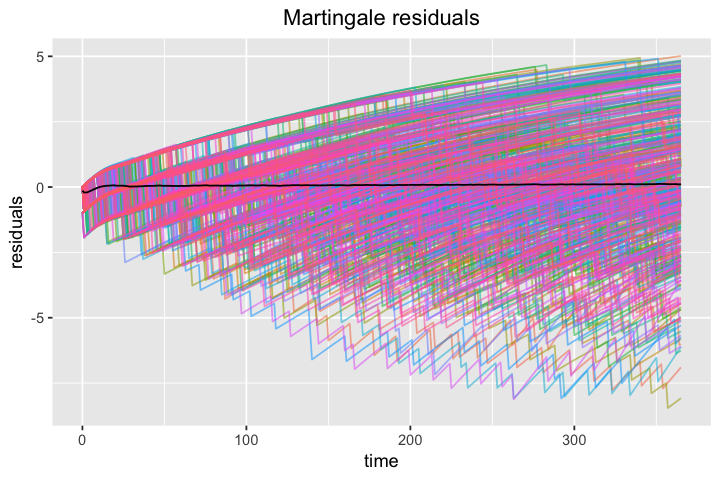

In [57]:
# select sample of patients to plot
sample_patients = sample(unique(sel_df$id),500)
sample = residuals[id %in% sample_patients,]

# plot
ggplot(data = mean_residuals, aes(x= time, y=residuals)) +
    geom_line() +
    geom_line(data = sample, aes(x= time, y=residuals, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line(data = mean_residuals, aes(x= time, y=residuals)) +
    ggtitle('Martingale residuals') +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

The average of the residuals is approximately 0